### Импортируем необходимые библиотеки

In [ ]:
pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import product
pd.set_option('display.max_columns', None)
import ast
from math import log2

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import optuna

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, precision_recall_curve, matthews_corrcoef)

import warnings
warnings.filterwarnings('ignore')

### Анализ и предобработка данных

In [ ]:
data = pd.read_csv('/content/12903_2018_591_MOESM1_ESM.csv')
data.head()

,Samples,Malodour,Cluster_3,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_28,Cluster_30,Cluster_31,Cluster_33,Cluster_34,Cluster_40,Cluster_54,Cluster_55,Cluster_59,Cluster_67,Cluster_81,Cluster_85,Cluster_87,Cluster_88,Cluster_91,Cluster_99,Cluster_116,Cluster_134,Cluster_168,Cluster_175,Cluster_211,Cluster_225,Cluster_265,Cluster_271,Cluster_281,Cluster_337,Cluster_497,Cluster_558,Cluster_644,Cluster_2338,Cluster_2466,Cluster_2471,Cluster_2474,Cluster_2475,Cluster_2478,Cluster_2483,Cluster_2484,Cluster_2487,Cluster_2488,Cluster_2490,Cluster_2496,Cluster_2499,Cluster_2505,Cluster_2507,Cluster_2529,Cluster_2599,Cluster_2820,Cluster_2862,Cluster_2863,Cluster_2907,Cluster_3096,Cluster_3115,Cluster_3116,Cluster_3118,Cluster_3122,Cluster_3128,Cluster_3142,Cluster_3144,Cluster_3156,Cluster_3276,Cluster_3304,Cluster_3380,Cluster_3392,Cluster_3396,Cluster_3408,Cluster_3413,Cluster_3414,Cluster_3427,Cluster_3430,Cluster_3452,Cluster_3453,Cluster_3480,Cluster_3484,Cluster_3489,Cluster_3510,Cluster_3527,Cluster_3557,Cluster_3574,Cluster_3585,Cluster_3592,Cluster_3601,Cluster_3702,Cluster_3703,Cluster_3704,Cluster_3709,Cluster_3715,Cluster_3726,Cluster_3731,Cluster_3732,Cluster_3746,Cluster_3751,Cluster_3769,Cluster_3792,Cluster_3818,Cluster_3838
0,Ig9373,N,10,166,87,328,4,45,526,71,16,573,10,4,1,0,0,125,14,29,0,13,15,1,12,32,14,0,0,0,0,1,0,0,80,3,6,0,0,0,1,0,0,0,17,0,0,0,12,0,11,0,0,3,0,0,0,0,0,9,0,16,11,4,0,54,0,142,0,71,1,1,264,41,6,0,0,19,0,0,1,0,5,6,0,0,0,0,0,0,0,0,10,0,0,0,1,1,0,1,2,0,2,0,0,3,0,0,0,0
1,Ig9374,N,15,350,237,33,1,0,519,37,71,217,129,1,0,23,43,9,17,3,92,9,11,0,0,2,0,6,1,1,0,2,0,0,1,0,26,3,8,0,3,0,0,0,14,0,1,0,241,1,4,0,0,1,0,1,0,0,0,13,0,19,25,11,0,10,0,449,2,34,2,0,108,6,3,0,13,0,2,0,5,0,0,2,16,2,7,0,2,2,0,0,1,0,0,0,1,8,2,0,1,0,0,0,1,0,0,0,0,0
2,Ig9375,N,24,112,168,62,102,0,547,150,134,145,118,3,2,13,7,2,3,1,0,61,15,0,0,1,11,125,1,2,0,2,1,4,1,1,25,4,0,1,1,0,0,0,19,0,4,5,18,5,5,0,0,0,0,1,0,8,0,65,0,52,13,8,1,14,10,192,27,49,2,5,71,35,19,0,162,15,5,0,9,2,9,2,0,14,17,0,2,1,0,4,2,0,0,0,1,46,0,4,5,0,0,11,65,9,0,7,0,7
3,Ig9376,N,27,195,117,59,102,20,882,139,135,339,106,8,0,14,34,2,7,0,0,2,1,0,0,1,0,3,0,6,0,0,3,2,1,4,4,0,0,0,12,0,0,0,17,1,7,0,78,3,1,0,0,3,0,0,0,0,0,42,0,71,23,13,1,39,7,80,1,55,0,1,15,1,0,0,4,1,4,0,1,16,0,0,1,2,11,0,4,6,12,2,0,1,0,1,0,21,0,7,5,0,0,3,63,18,5,9,0,1
4,Ig9377,N,48,167,222,18,0,2,544,79,94,322,58,3,0,5,28,5,0,0,2,13,1,0,0,3,2,1,0,1,1,0,0,3,0,0,1,0,0,0,1,0,0,0,5,14,11,6,324,0,3,1,0,0,0,0,0,0,0,10,0,26,34,7,4,0,9,438,5,21,1,1,62,60,11,0,9,0,26,1,2,0,0,0,0,4,25,5,7,0,0,0,1,0,0,2,0,12,30,0,2,0,0,6,26,22,3,0,0,0


In [ ]:
print(f'Данные представляют собой {data.shape[0]} записей c {data.shape[1]} уникальными признаками')

Данные представляют собой 90 записей c 110 уникальными признаками


In [ ]:
data['Malodour'] = le.fit_transform(data['Malodour'])

In [ ]:
data.drop('Samples', axis = 1, inplace = True)

In [ ]:
data = data.rename(columns={'Malodour': 'target'})

In [ ]:
data.describe()

,target,Cluster_3,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_28,Cluster_30,Cluster_31,Cluster_33,Cluster_34,Cluster_40,Cluster_54,Cluster_55,Cluster_59,Cluster_67,Cluster_81,Cluster_85,Cluster_87,Cluster_88,Cluster_91,Cluster_99,Cluster_116,Cluster_134,Cluster_168,Cluster_175,Cluster_211,Cluster_225,Cluster_265,Cluster_271,Cluster_281,Cluster_337,Cluster_497,Cluster_558,Cluster_644,Cluster_2338,Cluster_2466,Cluster_2471,Cluster_2474,Cluster_2475,Cluster_2478,Cluster_2483,Cluster_2484,Cluster_2487,Cluster_2488,Cluster_2490,Cluster_2496,Cluster_2499,Cluster_2505,Cluster_2507,Cluster_2529,Cluster_2599,Cluster_2820,Cluster_2862,Cluster_2863,Cluster_2907,Cluster_3096,Cluster_3115,Cluster_3116,Cluster_3118,Cluster_3122,Cluster_3128,Cluster_3142,Cluster_3144,Cluster_3156,Cluster_3276,Cluster_3304,Cluster_3380,Cluster_3392,Cluster_3396,Cluster_3408,Cluster_3413,Cluster_3414,Cluster_3427,Cluster_3430,Cluster_3452,Cluster_3453,Cluster_3480,Cluster_3484,Cluster_3489,Cluster_3510,Cluster_3527,Cluster_3557,Cluster_3574,Cluster_3585,Cluster_3592,Cluster_3601,Cluster_3702,Cluster_3703,Cluster_3704,Cluster_3709,Cluster_3715,Cluster_3726,Cluster_3731,Cluster_3732,Cluster_3746,Cluster_3751,Cluster_3769,Cluster_3792,Cluster_3818,Cluster_3838
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.00000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.500000,37.733333,167.455556,113.866667,101.933333,15.544444,55.077778,486.444444,221.922222,81.044444,287.966667,83.411111,3.122222,7.777778,7.500000,33.800000,10.922222,3.200000,3.444444,2.355556,10.477778,28.733333,2.622222,1.066667,3.288889,3.488889,18.788889,2.20000,4.088889,1.011111,1.066667,1.188889,1.711111,5.811111,2.833333,3.855556,0.755556,4.700000,1.588889,3.022222,0.822222,0.977778,1.600000,7.611111,2.822222,36.422222,16.955556,134.922222,6.644444,6.733333,4.333333,1.533333,2.277778,1.011111,3.111111,3.933333,2.833333,1.700000,52.644444,1.988889,60.644444,32.622222,10.900000,1.322222,11.133333,5.477778,240.755556,12.544444,26.544444,3.077778,1.055556,50.122222,48.200000,13.544444,1.655556,36.677778,5.500000,3.500000,0.933333,2.177778,4.833333,7.033333,2.211111,1.022222,7.577778,4.577778,1.377778,3.411111,5.755556,0.922222,1.677778,1.455556,1.266667,1.855556,1.188889,1.233333,35.811111,3.466667,6.100000,6.644444,1.088889,0.700000,5.988889,50.288889,14.322222,1.788889,0.977778,0.755556,0.755556
std,0.502801,36.344420,89.604770,63.260688,84.378601,21.913087,86.373272,184.405946,121.426561,65.302049,175.983940,91.177059,3.859405,12.032519,11.270175,65.236682,19.977644,3.490597,5.629200,11.238288,12.761624,38.201653,4.351360,3.609600,7.966566,4.319396,51.191971,2.85295,9.837608,1.464904,1.620098,2.556747,3.021438,14.657816,3.257662,7.261660,1.862167,33.069029,1.708501,2.971693,1.532991,1.437677,3.186347,9.203925,7.588545,55.273575,29.977112,122.976222,9.868018,8.411870,7.378986,2.942139,4.313626,2.675290,5.484287,10.515692,6.

In [ ]:
data.isnull().sum()

,0
target,0
Cluster_3,0
Cluster_13,0
Cluster_14,0
Cluster_15,0
...,...
Cluster_3751,0
Cluster_3769,0
Cluster_3792,0
Cluster_3818,0


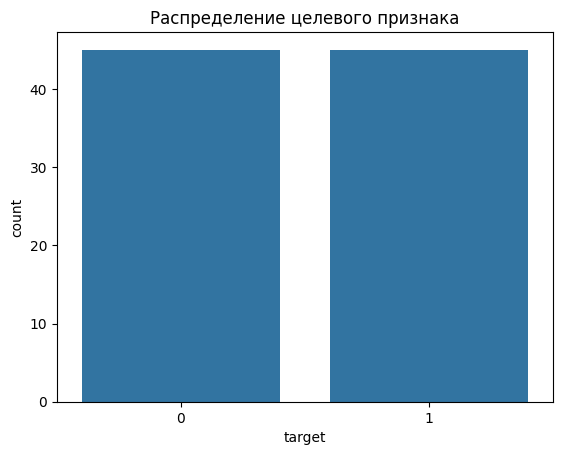

In [ ]:
sns.countplot(x='target', data=data)
plt.title('Распределение целевого признака')
plt.show()

In [ ]:
X = data.drop('target', axis = 1)
y = data['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Обучение и оценка моделей

#### LGBM

In [ ]:
def objective(trial):
    # Подбор гиперпараметров
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'num_leaves': trial.suggest_int('num_leaves', 5, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'random_state': 42,
        'n_jobs': -1
    }


    model = LGBMClassifier(**param, verbose = -1, is_unbalance=True)


    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')


    return scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print("Лучшие гиперпараметры:")
print(study.best_params)

[I 2025-06-26 13:40:34,080] A new study created in memory with name: no-name-ba107ab6-1dfe-4455-8197-c1df1b0144e0
[I 2025-06-26 13:40:35,339] Trial 0 finished with value: 0.6638095238095237 and parameters: {'n_estimators': 135, 'learning_rate': 0.030897134368263107, 'max_depth': 21, 'num_leaves': 14, 'min_child_samples': 28, 'subsample': 0.9656825618358619, 'colsample_bytree': 0.6881101374309926, 'reg_alpha': 0.0006623287401363065, 'reg_lambda': 0.024096209580968433, 'class_weight': 'balanced', 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.6638095238095237.
[I 2025-06-26 13:40:36,122] Trial 1 finished with value: 0.6914285714285715 and parameters: {'n_estimators': 119, 'learning_rate': 0.05300029543356663, 'max_depth': 12, 'num_leaves': 27, 'min_child_samples': 17, 'subsample': 0.9334041031135649, 'colsample_bytree': 0.5555202487549584, 'reg_alpha': 2.431005049462618e-07, 'reg_lambda': 0.009284975399020286, 'class_weight': None, 'boosting_type': 'gbdt'}. Best is trial 1 with 

Лучшие гиперпараметры:
{'n_estimators': 121, 'learning_rate': 0.037032206050914354, 'max_depth': 22, 'num_leaves': 18, 'min_child_samples': 6, 'subsample': 0.9450324571276203, 'colsample_bytree': 0.5168922999131728, 'reg_alpha': 0.00020363225438862172, 'reg_lambda': 1.0982226513039961e-05, 'class_weight': 'balanced', 'boosting_type': 'gbdt'}


In [ ]:
LGBM_model = LGBMClassifier(**study.best_params, verbose = -1, is_unbalance=True, random_state = 42)
LGBM_model.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred = LGBM_model.predict(X_test)
print("Accuracy на тесте:", accuracy_score(y_test, y_pred))

Accuracy на тесте: 0.8333333333333334


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(LGBM_model, X, y, cv=skf, scoring='accuracy')
for i in range(5):
  print(f'Fold {i+1}: Accuracy = {scores[i]}')
print('Mean accuracy:', scores.mean())

Fold 1: Accuracy = 0.5555555555555556
Fold 2: Accuracy = 0.8888888888888888
Fold 3: Accuracy = 0.8888888888888888
Fold 4: Accuracy = 0.6666666666666666
Fold 5: Accuracy = 0.8333333333333334
Mean accuracy: 0.7666666666666666


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[7 2]
 [1 8]]


#### XGBoost

In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBClassifier(**param)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    return scores.mean()

In [ ]:
study_2 = optuna.create_study(direction='maximize')
study_2.optimize(objective, n_trials=100)
print("Лучшие гиперпараметры:")
print(study_2.best_params)

[I 2025-06-26 13:41:27,383] A new study created in memory with name: no-name-be9ba978-1e91-43c0-ac86-cef20f4cff1a
[I 2025-06-26 13:41:28,242] Trial 0 finished with value: 0.49809523809523804 and parameters: {'n_estimators': 140, 'learning_rate': 0.026263370021068023, 'max_depth': 25, 'min_child_weight': 8, 'subsample': 0.7971407819908659, 'colsample_bytree': 0.7365229972654764, 'gamma': 1.6104531160882347, 'reg_alpha': 0.2193769826758705, 'reg_lambda': 1.2081108737063955e-07, 'scale_pos_weight': 34.98716631610279}. Best is trial 0 with value: 0.49809523809523804.
[I 2025-06-26 13:41:28,926] Trial 1 finished with value: 0.5971428571428572 and parameters: {'n_estimators': 108, 'learning_rate': 0.3218200424322595, 'max_depth': 25, 'min_child_weight': 2, 'subsample': 0.7489014493995809, 'colsample_bytree': 0.9484723124336405, 'gamma': 4.62100423242901, 'reg_alpha': 0.013753895558851469, 'reg_lambda': 1.3359524085764948e-05, 'scale_pos_weight': 24.463242885740204}. Best is trial 1 with valu

Лучшие гиперпараметры:
{'n_estimators': 91, 'learning_rate': 0.4932719237845232, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.5555593511976827, 'colsample_bytree': 0.828500453900431, 'gamma': 2.045899980225177, 'reg_alpha': 0.0046167298862344695, 'reg_lambda': 3.6367386624245456e-05, 'scale_pos_weight': 14.996359439392586}


In [ ]:
XGB_model = XGBClassifier(**study_2.best_params, random_state = 42)
XGB_model.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred = XGB_model.predict(X_test)
print("Accuracy на тесте:", accuracy_score(y_test, y_pred))

Accuracy на тесте: 0.7222222222222222


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(XGB_model, X, y, cv=skf, scoring='accuracy')
for i in range(5):
  print(f'Fold {i+1}: Accuracy = {scores[i]}')
print('Mean accuracy:', scores.mean())

Fold 1: Accuracy = 0.6111111111111112
Fold 2: Accuracy = 0.7777777777777778
Fold 3: Accuracy = 0.7222222222222222
Fold 4: Accuracy = 0.7777777777777778
Fold 5: Accuracy = 0.5
Mean accuracy: 0.6777777777777778


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[5 4]
 [1 8]]


#### Random Forest

In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**param)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    return scores.mean()

In [ ]:
study_3 = optuna.create_study(direction='maximize')
study_3.optimize(objective, n_trials=100)

print("Лучшие гиперпараметры:")
print(study_3.best_params)

[I 2025-06-26 13:43:58,818] A new study created in memory with name: no-name-fff8fe52-4840-4ed0-a68b-06b1e2f31038
[I 2025-06-26 13:44:00,413] Trial 0 finished with value: 0.679047619047619 and parameters: {'n_estimators': 139, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.679047619047619.
[I 2025-06-26 13:44:01,370] Trial 1 finished with value: 0.6628571428571428 and parameters: {'n_estimators': 84, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.679047619047619.
[I 2025-06-26 13:44:02,668] Trial 2 finished with value: 0.680952380952381 and parameters: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}. Best is trial 2 with value: 0.68095238095238

Лучшие гиперпараметры:
{'n_estimators': 133, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}


In [ ]:
RF_model = RandomForestClassifier(**study_3.best_params, random_state = 42)
RF_model.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred = RF_model.predict(X_test)
print("Accuracy на тесте:", accuracy_score(y_test, y_pred))

Accuracy на тесте: 0.7777777777777778


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(RF_model, X, y, cv=skf, scoring='accuracy')
for i in range(5):
  print(f'Fold {i+1}: Accuracy = {scores[i]}')
print('Mean accuracy:', scores.mean())

Fold 1: Accuracy = 0.5
Fold 2: Accuracy = 0.8333333333333334
Fold 3: Accuracy = 0.7777777777777778
Fold 4: Accuracy = 0.6666666666666666
Fold 5: Accuracy = 0.8333333333333334
Mean accuracy: 0.7222222222222222


### Сревнение моделей

In [ ]:
models = [LGBM_model, XGB_model, RF_model]
models_names = ['LGBM', 'XGBoost', 'Random_Forest']

def get_metrics(models_list, models_names):
  accuracy_metrics = []
  roc_auc_metrics = []
  f1_score_metrics = []
  precision_metrics = []
  recall_metrics = []
  mcc_metrics = []
  FP = []
  FN = []
  TP = []
  TN = []


  for model in models_list:
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    #threshold = 0.8
    #y_pred = (y_proba > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy_metrics.append(accuracy_score(y_test, y_pred))
    roc_auc_metrics.append(roc_auc_score(y_test, y_proba))
    f1_score_metrics.append(f1_score(y_test, y_pred))
    precision_metrics.append(precision_score(y_test, y_pred))
    recall_metrics.append(recall_score(y_test, y_pred))
    mcc_metrics.append(matthews_corrcoef(y_test, y_pred))
    FP.append(fp)
    FN.append(fn)
    TN.append(tn)
    TP.append(tp)

  data = pd.DataFrame({'model' : models_names,
                       'accuracy': accuracy_metrics,
                       'roc/auc': roc_auc_metrics,
                       'f1': f1_score_metrics,
                       'precision': precision_metrics,
                       'recall': recall_metrics,
                       'mcc': mcc_metrics,
                       'TN': TN,
                       'FP': FP,
                       'FN': FN,
                       'TP': TP})
  return data

In [ ]:
data = get_metrics(models, models_names)

In [ ]:
data

,model,accuracy,roc/auc,f1,precision,recall,mcc,TN,FP,FN,TP
0,LGBM,0.833333,0.901235,0.842105,0.800000,0.888889,0.670820,7,2,1,8
1,XGBoost,0.722222,0.814815,0.761905,0.666667,0.888889,0.471405,5,4,1,8
2,Random_Forest,0.777778,0.864198,0.750000,0.857143,0.666667,0.569803,8,1,3,6
